In [136]:
import numpy as np
import numpy.random

# Моделирование данных датчика
def simulateSensor(samplesCount, noiseSigma, dt):
   # Шум с нормальным распределением. мат. ожидание = 0, среднеквадратичное отклонение = noiseSigma

   sample1 = int(samplesCount/2)
   sample2 = samplesCount - sample1 
   noise1 = numpy.random.normal(loc = 0.0, scale = noiseSigma, size = sample1)
   noise2 = numpy.random.normal(loc = 0.0, scale = noiseSigma+ 0.0, size = sample2)
   noise = np.concatenate([noise1, noise2])
   
   trajectory = np.zeros((3, samplesCount))

   position = 0
   velocity = 1.0
   acceleration = 0.0

   for i in range(1, samplesCount):
       position = position + velocity * dt + (acceleration * dt ** 2) / 2.0
       velocity = velocity + acceleration * dt
       acceleration = acceleration

       trajectory[0][i] = position
       trajectory[1][i] = velocity
       trajectory[2][i] = acceleration

   measurement = trajectory[0] + noise

   return trajectory, measurement # Истинное значение и данные "датчика" с шумом

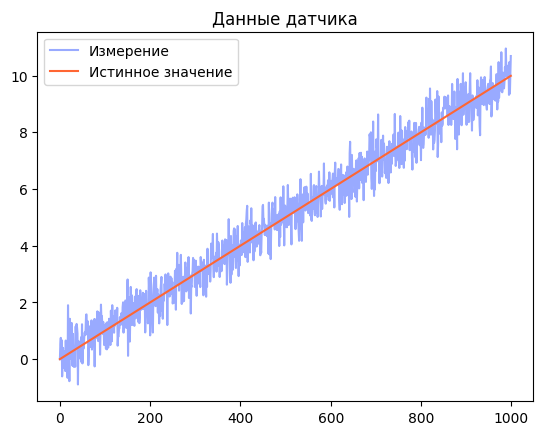

In [137]:
import matplotlib.pyplot as plt
dt = 0.01
measurementSigma = 0.5
trajectory, measurement = simulateSensor(1000, measurementSigma, dt)

plt.title("Данные датчика")
plt.plot(measurement, label="Измерение", color="#99AAFF")
plt.plot(trajectory[0], label="Истинное значение", color="#FF6633")
plt.legend()
plt.show()

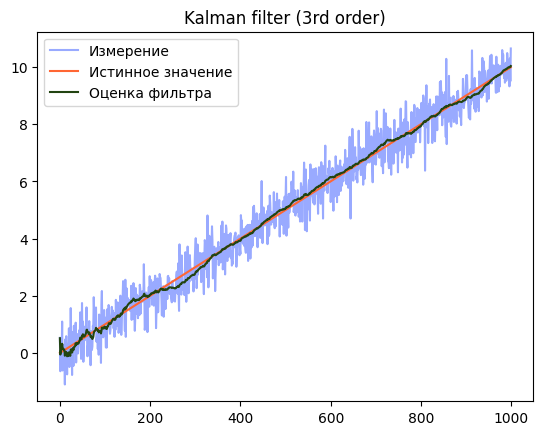

In [138]:
import filterpy.kalman
import filterpy.common
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
#from Simulator import simulateSensor # моделирование датчиков

dt = 0.01                       # Шаг времени
measurementSigma = 0.5          # Среднеквадратичное отклонение датчика
processNoise = 1e-4             # Погрешность модели
processNoiseVariance = 1e-4

# Моделирование данных датчиков
trajectory, measurement = simulateSensor(1000, measurementSigma, dt)

# Создаём объект KalmanFilter
filter = filterpy.kalman.KalmanFilter(dim_x=3,      # Размер вектора стостояния
                                     dim_z=1)      # Размер вектора измерений

# F - матрица процесса - размер dim_x на dim_x - 3х3
filter.F = np.array([ [1,   dt,     (dt**2)/2],
                     [0,   1.0,    dt],
                     [0,   0,      1.0]])


# Матрица наблюдения - dim_z на dim_x - 1x3
filter.H = np.array([[1.0, 0.0, 0.0]])

# Ковариационная матрица ошибки модели
filter.Q = filterpy.common.Q_discrete_white_noise(dim=3, dt=dt, var=processNoiseVariance)

# Ковариационная матрица ошибки измерения - 1х1
filter.R =np.array([[measurementSigma*measurementSigma]])

# Начальное состояние.
filter.x = np.array([0.0, 0.0, 0.0])

# Ковариационная матрица для начального состояния
filter.P = np.array([[10.0, 0.0,  0.0],
                    [0.0,  10.0, 0.0],
                    [0.0,  0.0,  10.0]])

filteredState = []
stateCovarianceHistory = []



# Обработка данных
for i in range(0, len(measurement)):
   z = [ measurement[i] ]                      # Вектор измерений
   filter.predict()                            # Этап предсказания
   
   filter.update(z)                            # Этап коррекции
   filteredState.append(filter.x)
   stateCovarianceHistory.append(filter.P)
   
 

filteredState = np.array(filteredState)
stateCovarianceHistory = np.array(stateCovarianceHistory)

# Визуализация
plt.title("Kalman filter (3rd order)")
plt.plot(measurement, label="Измерение", color="#99AAFF")
plt.plot(trajectory[0], label="Истинное значение", color="#FF6633")
plt.plot(filteredState[:, 0], label="Оценка фильтра", color="#224411")
plt.legend()
plt.show()